# FL-SEND Diarization Notebook

This notebook demonstrates data preparation, feature extraction, model definition, and training for the FL-SEND (Federated Speaker Embedding-aware Neural Diarization) project. It includes steps to:
- Load the AMI dataset via Hugging Face.
- Group data by meeting ID to simulate realistic overlapping speech.
- Apply power-set encoding to represent overlapping speaker labels.
- Simulate overlapping speech segments.
- Extract log-Mel spectrogram features.
- Build the SEND model architecture.
- Create PyTorch datasets and dataloaders.
- Train the model and evaluate using Diarization Error Rate (DER).

In [1]:
# Install required packages
!pip install numpy librosa torch torchaudio scikit-learn datasets speechbrain pyannote.metrics

## 1. Load and Prepare the Dataset

We load the AMI dataset using the Hugging Face datasets library. The dataset is then grouped by meeting ID to simulate overlapping speech scenarios.

In [2]:
from datasets import load_dataset
import os
from IPython.display import Audio

# Load the AMI dataset (using a subset for quick experiments)
dataset = load_dataset("edinburghcstr/ami", 'ihm')

# Function to group samples by meeting_id
def group_by_meeting(dataset):
    grouped = {}
    for sample in dataset:
        meeting_id = sample["meeting_id"]
        if meeting_id not in grouped:
            grouped[meeting_id] = []
        grouped[meeting_id].append(sample)
    return grouped

# Group train, validation, and test splits (using first 5000 samples for each)
grouped_train = group_by_meeting(dataset["train"].select(range(5000)))
grouped_validation = group_by_meeting(dataset["validation"].select(range(5000)))
grouped_test = group_by_meeting(dataset["test"].select(range(5000)))

/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check a Sample from a Group

Display some details (begin time, end time, audio array length) of the first sample in meeting 'EN2001a'.

In [3]:
print("Begin Time:", grouped_train['EN2001a'][0]['begin_time'])
print("End Time:", grouped_train['EN2001a'][0]['end_time'])
print("Audio Array Length:", len(grouped_train['EN2001a'][0]['audio']['array']))

Begin Time: 3302.969970703125
End Time: 3307.179931640625
Audio Array Length: 67360


### Display Available Meeting IDs

Print the keys (meeting IDs) in the training data.

In [4]:
print("Meeting IDs in train set:", list(grouped_train.keys()))

Meeting IDs in train set: ['EN2001a', 'EN2001b', 'EN2001d', 'EN2001e']


### Determine Maximum Number of Speakers

We compute the maximum number of speakers present in any meeting across train, validation, and test sets.

In [5]:
max_train_speakers = max(len(set(sample["speaker_id"] for sample in group)) for group in grouped_train.values())
max_val_speakers = max(len(set(sample["speaker_id"] for sample in group)) for group in grouped_validation.values())
max_test_speakers = max(len(set(sample["speaker_id"] for sample in group)) for group in grouped_test.values())

num_speakers = max(max_train_speakers, max_val_speakers, max_test_speakers)
print(f"Maximum number of speakers across all datasets: {num_speakers}")

Maximum number of speakers across all datasets: 5


## 2. Power-Set Encoding

The power-set encoding function converts a binary speaker activation vector into a single integer label.

In [6]:
def power_set_encoding(labels):
    """
    Encodes a multi-label speaker activation vector into a single integer using power-set encoding.
    Only binary values (0 or 1) are considered.
    """
    return sum([l * (2 ** i) for i, l in enumerate(labels) if l in [0, 1]])

## 3. Overlapping Speech Simulation

For each meeting, we randomly choose a set of speakers (ensuring at least two are available) and simulate overlapping speech by summing their audio signals.
We generate 50 overlapping segments per meeting.

In [7]:
import random
import numpy as np

def simulate_overlap(grouped_data, num_speakers=2, duration=10, sampling_rate=16000):
    overlapping_segments = []
    labels = []
    for meeting_id, samples in grouped_data.items():
        # Group samples by speaker_id within the meeting
        speakers = {sample["speaker_id"]: [] for sample in samples}
        for sample in samples:
            speakers[sample["speaker_id"]].append(sample)
        if len(speakers) < num_speakers:
            continue  # Skip meetings with fewer than required speakers
        for _ in range(50):
            chosen_speakers = random.sample(list(speakers.keys()), num_speakers)
            combined_signal = None
            speaker_label = [0] * len(speakers)
            for speaker_id in chosen_speakers:
                sample = random.choice(speakers[speaker_id])
                signal = sample["audio"]["array"]
                # Ensure the signal is exactly the desired duration
                if len(signal) > duration * sampling_rate:
                    signal = signal[: duration * sampling_rate]
                else:
                    signal = np.pad(signal, (0, duration * sampling_rate - len(signal)), mode="constant")
                if combined_signal is None:
                    combined_signal = signal
                else:
                    combined_signal += signal
                # Mark speaker as active in the meeting
                speaker_label[list(speakers.keys()).index(speaker_id)] = 1
            # Normalize the combined signal
            if combined_signal is not None and np.max(np.abs(combined_signal)) > 0:
                combined_signal = combined_signal / np.max(np.abs(combined_signal))
            else:
                continue
            overlapping_segments.append(combined_signal)
            labels.append(power_set_encoding(speaker_label))
    # Debug: Print a few sample encoded labels
    print("Sample Power-Set Encoded Labels (Train):", labels[:10])
    return overlapping_segments, labels

## 4. Visualize Label Distribution

Plot a histogram of the power-set encoded labels from the training set to check their distribution.

Sample Power-Set Encoded Labels (Train): [12, 24, 10, 5, 20, 9, 6, 5, 6, 24]


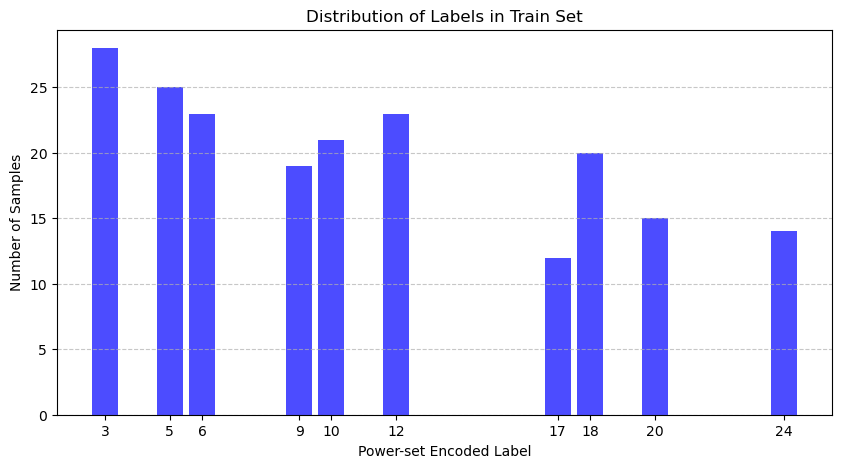

In [8]:
import matplotlib.pyplot as plt

# For demonstration, assume train_labels has been generated after simulation
# (simulate on training data)
_, train_labels = simulate_overlap(grouped_train)
unique_labels, counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(unique_labels, counts, color='blue', alpha=0.7)
plt.xlabel("Power-set Encoded Label")
plt.ylabel("Number of Samples")
plt.title("Distribution of Labels in Train Set")
plt.xticks(unique_labels)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## 5. Feature Extraction

Convert overlapping audio segments into log-Mel spectrogram features for model input.

In [9]:
import librosa

def extract_features_batch(segments, sr=16000, n_mels=80, win_length=0.025, hop_length=0.01, max_frames=None):
    features = []
    win_length_samples = int(win_length * sr)
    hop_length_samples = int(hop_length * sr)
    for segment in segments:
        mel_spec = librosa.feature.melspectrogram(
            y=segment, sr=sr, n_mels=n_mels, win_length=win_length_samples, hop_length=hop_length_samples
        )
        log_mel = librosa.power_to_db(mel_spec)
        # Optionally pad or truncate to max_frames
        if max_frames:
            if log_mel.shape[1] > max_frames:
                log_mel = log_mel[:, :max_frames]
            else:
                log_mel = np.pad(log_mel, ((0, 0), (0, max_frames - log_mel.shape[1])), mode="constant")
        features.append(log_mel.T)  # Transpose to (time, features)
    features = np.array(features, dtype=np.float32)
    return torch.tensor(features, dtype=torch.float32)

## 6. Model Architecture Definition

Define the SEND model using PyTorch. The model includes:
- A speech encoder (bidirectional LSTM).
- A speaker encoder (pretrained, frozen ECAPA-TDNN from SpeechBrain).
- Context-independent and context-dependent scoring branches.
- A final projection to the power-set encoded label space.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Speech Encoder: Uses bidirectional LSTM.
class SpeechEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
    def forward(self, x):
        # Ensure x is of shape (batch, seq_len, features)
        if x.dim() == 4:
            x = x.squeeze(1)
        x, _ = self.lstm(x)
        return x

# SEND Model: Integrates speech encoder, pretrained speaker encoder, transformer, and post-processing.
class SEND(nn.Module):
    def __init__(self, input_dim, speaker_dim, hidden_dim, num_layers, num_speakers):
        super().__init__()
        self.speech_encoder = SpeechEncoder(input_dim, hidden_dim, num_layers)
        # Use the pretrained speaker encoder from SpeechBrain (frozen)
        from speechbrain.pretrained import EncoderClassifier
        self.speaker_encoder = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-ecapa-voxceleb",
            savedir="pretrained_models/spkrec-ecapa",
            run_opts={"device": device}
        ).to(device)
        for param in self.speaker_encoder.parameters():
            param.requires_grad = False
        
        self.feature_projection = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.context_independent = nn.Linear(hidden_dim * 2, num_speakers)
        self.context_dependent = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_dim * 2, 4), num_layers
        )
        self.match_projection = nn.Linear(hidden_dim * 2, num_speakers)
        # Final output dimension is 2^(num_speakers) for power-set encoding
        self.post_net = nn.Linear(num_speakers * 2, 2 ** num_speakers)

    def forward(self, speech):
        if speech.dim() == 4:
            speech = speech.squeeze(1)
        speech_features = self.speech_encoder(speech)  # [batch, time, hidden_dim * 2]
        speech_features = self.feature_projection(speech_features)
        # Process context-dependent branch
        # Permute for Transformer: (time, batch, features)
        speech_features_t = speech_features.permute(1, 0, 2)
        cd_scores = self.context_dependent(speech_features_t)
        cd_scores = cd_scores.permute(1, 0, 2)
        cd_scores = self.match_projection(cd_scores)
        # Process context-independent branch
        ci_scores = self.context_independent(speech_features)
        # Ensure both branches have same shape and concatenate
        assert ci_scores.shape == cd_scores.shape, f"Shape mismatch: {ci_scores.shape} vs {cd_scores.shape}"
        combined = torch.cat([ci_scores, cd_scores], dim=-1)
        return self.post_net(combined)

/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## 7. Data Loading and Dataset Preparation

Create a custom PyTorch dataset class that provides feature and label pairs for training and evaluation.

In [11]:
from torch.utils.data import Dataset, DataLoader

class OverlappingSpeechDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels  # Assumed to be mapped to integers for classification

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        # Expand label to match sequence length (for each frame)
        label = label.expand(feature.shape[0])
        return feature, label

## 8. Training and Evaluation Functions

Define the training loop (with mixed precision scaling) and evaluation using Diarization Error Rate (DER) via pyannote.metrics.

In [12]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from pyannote.metrics.diarization import DiarizationErrorRate
from scipy.stats import mode

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "mps" if torch.backends.mps.is_available() else "cpu"
scaler = GradScaler()

def train(model, train_loader, val_loader, epochs, save_path="send_checkpoint.pth"):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        num_classes = 2 ** num_speakers
        for features, labels in train_loader:
            model.train()
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(features)
                labels = labels.view(-1)  # Flatten labels
                outputs = outputs.view(-1, num_classes)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}")
        model.eval()
        val_der = calculate_der(model, val_loader, num_speakers)
        print(f"Epoch {epoch+1}/{epochs} - Validation DER: {val_der:.2%}")
        torch.save(model.state_dict(), save_path)
    print("Training complete.")

def labels_to_annotation(labels, num_speakers, frame_duration=0.01):
    from pyannote.core import Annotation, Segment
    annotation = Annotation()
    # Convert tensor/array to list if necessary
    if isinstance(labels, (np.ndarray, torch.Tensor)):
        labels = labels.flatten().tolist()
    # Use mode to obtain the most frequent label
    label = int(mode(labels, keepdims=True)[0][0])
    print(f"Decoded Label: {label}")
    active_speakers = [bool(label & (1 << i)) for i in range(num_speakers)]
    start_time = 0
    end_time = len(labels) * frame_duration
    for idx, active in enumerate(active_speakers):
        if active:
            annotation[Segment(start_time, end_time)] = f"Speaker_{idx}"
    return annotation

def calculate_der(model, test_loader, num_speakers):
    der_metric = DiarizationErrorRate()
    model.eval()
    total_der = 0
    num_samples = 0
    with torch.no_grad():
        for i, (features, labels) in enumerate(test_loader):
            features = features.to(device)
            outputs = model(features)
            predicted_labels = torch.argmax(outputs, dim=-1).cpu().numpy()
            labels = labels.cpu().numpy()
            for j in range(len(labels)):
                ref_annotation = labels_to_annotation(labels[j], num_speakers)
                hyp_annotation = labels_to_annotation(predicted_labels[j], num_speakers)
                der = der_metric(ref_annotation, hyp_annotation)
                print(f"Sample {i}-{j} DER: {der:.2%}")
                total_der += der
                num_samples += 1
    avg_der = total_der / num_samples if num_samples > 0 else 0
    print(f"Final Average DER: {avg_der:.2%}")
    return avg_der

/var/folders/h5/1l91py_s0z5fnb4pslfjscpm0000gn/T/ipykernel_25682/2566572613.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


## 9. Prepare Data for Training

Simulate overlapping speech segments, extract features, map labels, and create PyTorch dataloaders.

In [13]:
# Simulate overlapping speech for each split
train_segments, train_labels = simulate_overlap(grouped_train)
val_segments, val_labels = simulate_overlap(grouped_validation)
test_segments, test_labels = simulate_overlap(grouped_test)

# Print unique labels and their distribution in training set
from collections import Counter
print("Unique Labels in Training Set:", set(train_labels))
label_counts = Counter(train_labels)
for label, count in label_counts.items():
    binary_repr = bin(label)[2:].zfill(num_speakers)
    print(f"Label: {label}, Binary: {binary_repr}, Count: {count}")

# Map labels to continuous indices for classification
unique_labels = sorted(set(train_labels + val_labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
print(f"Label Mapping: {label_to_index}")

# Apply mapping to training and validation labels
train_labels = [label_to_index[label] for label in train_labels]
val_labels = [label_to_index[label] for label in val_labels]

# Extract features with fixed maximum frames (10 sec duration, hop_length=0.01 → 1000 frames)
max_frames = int(10 / 0.01)
train_features = extract_features_batch(train_segments, max_frames=max_frames)
val_features = extract_features_batch(val_segments, max_frames=max_frames)
test_features = extract_features_batch(test_segments, max_frames=max_frames)

# Create DataLoader objects
train_loader = DataLoader(OverlappingSpeechDataset(train_features, train_labels), batch_size=16, shuffle=True)
val_loader = DataLoader(OverlappingSpeechDataset(val_features, val_labels), batch_size=16, shuffle=False)
test_loader = DataLoader(OverlappingSpeechDataset(test_features, test_labels), batch_size=16, shuffle=False)

Sample Power-Set Encoded Labels (Train): [18, 6, 17, 9, 12, 17, 18, 3, 24, 17]
Sample Power-Set Encoded Labels (Train): [3, 6, 3, 12, 3, 12, 5, 9, 5, 3]
Sample Power-Set Encoded Labels (Train): [10, 9, 9, 10, 12, 3, 3, 3, 12, 9]
Unique Labels in Training Set: {3, 5, 6, 9, 10, 12, 17, 18, 20, 24}
Label: 18, Binary: 10010, Count: 16
Label: 6, Binary: 00110, Count: 25
Label: 17, Binary: 10001, Count: 17
Label: 9, Binary: 01001, Count: 24
Label: 12, Binary: 01100, Count: 19
Label: 3, Binary: 00011, Count: 22
Label: 24, Binary: 11000, Count: 18
Label: 5, Binary: 00101, Count: 23
Label: 10, Binary: 01010, Count: 24
Label: 20, Binary: 10100, Count: 12
Label Mapping: {3: 0, 5: 1, 6: 2, 9: 3, 10: 4, 12: 5, 17: 6, 18: 7, 20: 8, 24: 9}


## 10. Train the SEND Model

Initialize the model and start training for a fixed number of epochs.

In [14]:
# Set number of speakers based on earlier calculation (or adjust as needed)
num_speakers = 5  # This should reflect the maximum expected speakers per meeting
model = SEND(input_dim=80, speaker_dim=512, hidden_dim=256, num_layers=4, num_speakers=num_speakers).to(device)
train(model, train_loader, val_loader, epochs=10)

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
/var/folders/h5/1l91py_s0z5fnb4pslfjscpm0000gn/T/ipykernel_25682/2603438722.py:23: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.am

Epoch 1/10 - Train Loss: 3.2430
Decoded Label: 0
Decoded Label: 4
Sample 0-0 DER: 100.00%
Decoded Label: 2
Decoded Label: 4
Sample 0-1 DER: 0.00%
Decoded Label: 0
Decoded Label: 4
Sample 0-2 DER: 100.00%
Decoded Label: 5
Decoded Label: 4
Sample 0-3 DER: 0.00%
Decoded Label: 0
Decoded Label: 4
Sample 0-4 DER: 100.00%
Decoded Label: 5
Decoded Label: 4
Sample 0-5 DER: 0.00%
Decoded Label: 1
Decoded Label: 4
Sample 0-6 DER: 0.00%
Decoded Label: 3
Decoded Label: 4
Sample 0-7 DER: 0.00%
Decoded Label: 1
Decoded Label: 4
Sample 0-8 DER: 0.00%
Decoded Label: 0
Decoded Label: 4
Sample 0-9 DER: 100.00%
Decoded Label: 1
Decoded Label: 4
Sample 0-10 DER: 0.00%
Decoded Label: 1
Decoded Label: 4
Sample 0-11 DER: 0.00%
Decoded Label: 4
Decoded Label: 4
Sample 0-12 DER: 0.00%
Decoded Label: 4
Decoded Label: 4
Sample 0-13 DER: 0.00%
Decoded Label: 4
Decoded Label: 4
Sample 0-14 DER: 0.00%
Decoded Label: 1
Decoded Label: 4
Sample 0-15 DER: 0.00%


/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/pyannote/metrics/utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


Decoded Label: 3
Decoded Label: 4
Sample 1-0 DER: 0.00%
Decoded Label: 4
Decoded Label: 4
Sample 1-1 DER: 0.00%
Decoded Label: 2
Decoded Label: 4
Sample 1-2 DER: 0.00%
Decoded Label: 5
Decoded Label: 4
Sample 1-3 DER: 0.00%
Decoded Label: 1
Decoded Label: 4
Sample 1-4 DER: 0.00%
Decoded Label: 2
Decoded Label: 4
Sample 1-5 DER: 0.00%
Decoded Label: 1
Decoded Label: 4
Sample 1-6 DER: 0.00%
Decoded Label: 0
Decoded Label: 4
Sample 1-7 DER: 100.00%
Decoded Label: 4
Decoded Label: 4
Sample 1-8 DER: 0.00%
Decoded Label: 2
Decoded Label: 4
Sample 1-9 DER: 0.00%
Decoded Label: 3
Decoded Label: 4
Sample 1-10 DER: 0.00%
Decoded Label: 5
Decoded Label: 4
Sample 1-11 DER: 0.00%
Decoded Label: 0
Decoded Label: 4
Sample 1-12 DER: 100.00%
Decoded Label: 4
Decoded Label: 4
Sample 1-13 DER: 0.00%
Decoded Label: 4
Decoded Label: 4
Sample 1-14 DER: 0.00%
Decoded Label: 1
Decoded Label: 4
Sample 1-15 DER: 0.00%
Decoded Label: 2
Decoded Label: 4
Sample 2-0 DER: 0.00%
Decoded Label: 0
Decoded Label: 4
Samp

## 11. Debug Model Predictions

Check a few predictions on the validation set to inspect ground truth versus predicted labels.

In [15]:
def debug_predictions(model, test_loader, num_speakers):
    model.eval()
    with torch.no_grad():
        for i, (features, labels) in enumerate(test_loader):
            features = features.to(device)
            outputs = model(features)
            predicted_labels = torch.argmax(outputs, dim=-1).cpu().numpy()
            labels = labels.cpu().numpy()
            print(f"\nSample {i}")
            print("Ground Truth:", labels)
            print("Predictions:  ", predicted_labels)
            if np.all(predicted_labels == 0):
                print("⚠️ Warning: Model predicts only silence!")
            if i >= 5:
                break

debug_predictions(model, val_loader, num_speakers)

/var/folders/h5/1l91py_s0z5fnb4pslfjscpm0000gn/T/ipykernel_25682/1898312540.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[idx], dtype=torch.float32)



Sample 0
Ground Truth: [[0 0 0 ... 0 0 0]
 [2 2 2 ... 2 2 2]
 [0 0 0 ... 0 0 0]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [1 1 1 ... 1 1 1]]
Predictions:   [[ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]
 [21 21 21 ... 21 21 21]
 ...
 [ 8  8  8 ...  8  8  8]
 [ 8  8  8 ... 15 15 15]
 [ 4  4  4 ...  4  4  4]]

Sample 1
Ground Truth: [[3 3 3 ... 3 3 3]
 [4 4 4 ... 4 4 4]
 [2 2 2 ... 2 2 2]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [1 1 1 ... 1 1 1]]
Predictions:   [[ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  8  8  4]
 [21 21 21 ... 21 21 21]
 ...
 [ 8  8  8 ...  8  8  8]
 [ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]]

Sample 2
Ground Truth: [[2 2 2 ... 2 2 2]
 [0 0 0 ... 0 0 0]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [3 3 3 ... 3 3 3]
 [2 2 2 ... 2 2 2]]
Predictions:   [[ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]
 ...
 [15 15 15 ... 15 15 15]
 [ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]]

Sample 3
Ground Truth: [[4 4 4 ... 4 4 4]
 [4 4 4 ... 

## 12. Evaluate Diarization Error Rate (DER)

Use the pyannote.metrics library to compute DER for each sample in the test set.

In [16]:
calculate_der(model, test_loader, num_speakers)

/var/folders/h5/1l91py_s0z5fnb4pslfjscpm0000gn/T/ipykernel_25682/1898312540.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[idx], dtype=torch.float32)


Decoded Label: 10
Decoded Label: 8
Sample 0-0 DER: 0.00%
Decoded Label: 9
Decoded Label: 8
Sample 0-1 DER: 0.00%
Decoded Label: 9
Decoded Label: 8
Sample 0-2 DER: 0.00%
Decoded Label: 10
Decoded Label: 0
Sample 0-3 DER: 100.00%
Decoded Label: 12
Decoded Label: 0
Sample 0-4 DER: 100.00%
Decoded Label: 3
Decoded Label: 21
Sample 0-5 DER: 0.00%
Decoded Label: 3
Decoded Label: 21
Sample 0-6 DER: 0.00%
Decoded Label: 3
Decoded Label: 8
Sample 0-7 DER: 0.00%
Decoded Label: 12
Decoded Label: 4
Sample 0-8 DER: 0.00%
Decoded Label: 9
Decoded Label: 8
Sample 0-9 DER: 0.00%
Decoded Label: 6
Decoded Label: 9
Sample 0-10 DER: 0.00%
Decoded Label: 10
Decoded Label: 4
Sample 0-11 DER: 0.00%
Decoded Label: 10
Decoded Label: 8
Sample 0-12 DER: 0.00%
Decoded Label: 10
Decoded Label: 15
Sample 0-13 DER: 0.00%
Decoded Label: 12
Decoded Label: 21
Sample 0-14 DER: 0.00%
Decoded Label: 6
Decoded Label: 4
Sample 0-15 DER: 0.00%
Decoded Label: 3
Decoded Label: 21
Sample 1-0 DER: 0.00%
Decoded Label: 3
Decoded 

0.1

In [17]:
# %%
"""
Cell 1: Import all necessary packages and libraries.
Unused libraries are removed and all imports are consolidated here.
"""
import os
import pickle
from collections import OrderedDict
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import librosa
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset, random_split

import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context

from pyannote.core import Segment, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate

# (No progress bar disabling code is needed here.)


2025-02-26 07:28:03,154	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [18]:
with open("preprocessed_callhome_data.pkl", "rb") as f:
    preprocessed_data = pickle.load(f)
extracted_segments = preprocessed_data.get("extracted_segments", [])
print(f"Total extracted segments: {len(extracted_segments)}")

# Load the original dataset for retrieving audio snippets
from datasets import load_dataset
dataset = load_dataset("talkbank/callhome", "eng", split="data")
print(f"Original dataset contains {len(dataset)} samples.")

Total extracted segments: 13358
Original dataset contains 140 samples.


In [19]:
# %%
"""
Cell 2: Set up the device and print version information for Flower and PyTorch.
Uses Apple MPS if available; otherwise, defaults to CPU.
"""
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {fl.__version__} / PyTorch {torch.__version__}")


Training on mps
Flower 1.15.2 / PyTorch 2.6.0


In [20]:
import itertools

def generate_pair_encoding_map(label_list):
    """
    Generates an encoding map for speaker pair combinations from the given label list.
    This includes:
      - The empty tuple () for silence.
      - Single speaker cases: (x, x) for each x in label_list.
      - Ordered pairs for two distinct speakers (order-sensitive).
    """
    encoding_map = {}
    code = 0
    # Silence: no speaker active
    encoding_map[tuple()] = code
    code += 1
    # Single speaker cases
    for label in label_list:
        encoding_map[(label, label)] = code
        code += 1
    # Ordered pairs: two distinct speakers (order matters)
    for pair in itertools.permutations(label_list, 2):
        encoding_map[pair] = code
        code += 1
    return encoding_map

# Define your label set.
labels_set = ['B2', 'A1', 'B', 'B1', 'A']

# Generate the encoding map for pair combinations.
encoding_map = generate_pair_encoding_map(labels_set)

# Example: print the mapping.
print("Encoding Map:")
for k, v in encoding_map.items():
    print(k, ":", v,",")



Encoding Map:
() : 0 ,
('B2', 'B2') : 1 ,
('A1', 'A1') : 2 ,
('B', 'B') : 3 ,
('B1', 'B1') : 4 ,
('A', 'A') : 5 ,
('B2', 'A1') : 6 ,
('B2', 'B') : 7 ,
('B2', 'B1') : 8 ,
('B2', 'A') : 9 ,
('A1', 'B2') : 10 ,
('A1', 'B') : 11 ,
('A1', 'B1') : 12 ,
('A1', 'A') : 13 ,
('B', 'B2') : 14 ,
('B', 'A1') : 15 ,
('B', 'B1') : 16 ,
('B', 'A') : 17 ,
('B1', 'B2') : 18 ,
('B1', 'A1') : 19 ,
('B1', 'B') : 20 ,
('B1', 'A') : 21 ,
('A', 'B2') : 22 ,
('A', 'A1') : 23 ,
('A', 'B') : 24 ,
('A', 'B1') : 25 ,


In [79]:
def power_set_encoding(labels):
    """Encodes speaker pairs into a fixed label mapping.
    
    If labels is a string, it wraps it in a list. Otherwise, it expects a list of strings.
    """
    # If a single label string is provided, wrap it into a list.
    if isinstance(labels, str):
        labels = [labels]
    
    if not labels or not isinstance(labels, list):
        print(f"❌ Invalid labels: {labels}")  # Debug
        return 0  # If no one is speaking, return 0

    # Define the mapping explicitly.
    encoding_map = {
        tuple(): 0,
        ('B2', 'B2'): 1,
        ('A1', 'A1'): 2,
        ('B', 'B'): 3,
        ('B1', 'B1'): 4,
        ('A', 'A'): 5,
        ('B2', 'A1'): 6,
        ('B2', 'B'): 7,
        ('B2', 'B1'): 8,
        ('B2', 'A'): 9,
        ('A1', 'B2'): 10,
        ('A1', 'B'): 11,
        ('A1', 'B1'): 12,
        ('A1', 'A'): 13,
        ('B', 'B2'): 14,
        ('B', 'A1'): 15,
        ('B', 'B1'): 16,
        ('B', 'A'): 17,
        ('B1', 'B2'): 18,
        ('B1', 'A1'): 19,
        ('B1', 'B'): 20,
        ('B1', 'A'): 21,
        ('A', 'B2'): 22,
        ('A', 'A1'): 23,
        ('A', 'B'): 24,
        ('A', 'B1'): 25 
    }

    # Convert list to tuple for lookup (order is preserved).
    key = tuple(labels)
    encoded_label = encoding_map.get(key, -1)

    if encoded_label == -1:
        print(f"❌ Unexpected speaker combination: {labels}, setting to 0")
        encoded_label = 0  # Default to silence if unexpected case appears

    return encoded_label


In [22]:
# Load preprocessed dataset
with open("preprocessed_callhome_data.pkl", "rb") as f:
    preprocessed_data = pickle.load(f)
extracted_segments = preprocessed_data.get("extracted_segments", [])
print(f"Total extracted segments: {len(extracted_segments)}")

Total extracted segments: 13358


In [66]:
# Collect unique speaker labels
unique_speaker_labels = set()

for seg in extracted_segments:
    unique_speaker_labels.update(seg["speakers"])

print(f"🔍 Unique speaker labels in dataset: {unique_speaker_labels}")

🔍 Unique speaker labels in dataset: {'A1', 'B1', 'A', 'B', 'B2'}


In [67]:
# ✅ Debug: Check if all extracted segments have valid labels
for i, seg in enumerate(extracted_segments[:50]):  # First 10 samples
    label = power_set_encoding(seg["speakers"])
    print(f"🔍 Segment {i} Speakers: {seg['speakers']}, Encoded Label: {label}")

🔍 Segment 0 Speakers: ['A', 'B'], Encoded Label: 24
🔍 Segment 1 Speakers: ['B', 'A'], Encoded Label: 17
🔍 Segment 2 Speakers: ['A', 'B'], Encoded Label: 24
🔍 Segment 3 Speakers: ['A', 'B'], Encoded Label: 24
🔍 Segment 4 Speakers: ['B', 'A'], Encoded Label: 17
🔍 Segment 5 Speakers: ['A', 'B'], Encoded Label: 24
🔍 Segment 6 Speakers: ['B', 'A'], Encoded Label: 17
🔍 Segment 7 Speakers: ['B', 'A'], Encoded Label: 17
🔍 Segment 8 Speakers: ['B', 'A'], Encoded Label: 17
🔍 Segment 9 Speakers: ['A', 'B'], Encoded Label: 24
🔍 Segment 10 Speakers: ['A', 'B'], Encoded Label: 24
🔍 Segment 11 Speakers: ['A', 'B'], Encoded Label: 24
🔍 Segment 12 Speakers: ['B', 'A'], Encoded Label: 17
🔍 Segment 13 Speakers: ['B', 'A'], Encoded Label: 17
🔍 Segment 14 Speakers: ['A', 'B'], Encoded Label: 24
🔍 Segment 15 Speakers: ['B', 'A'], Encoded Label: 17
🔍 Segment 16 Speakers: ['B', 'A'], Encoded Label: 17
🔍 Segment 17 Speakers: ['A', 'B'], Encoded Label: 24
🔍 Segment 18 Speakers: ['B', 'A'], Encoded Label: 17
🔍 S

In [68]:
from collections import Counter

all_speaker_labels = [tuple(sorted(seg["speakers"])) for seg in extracted_segments]
speaker_count = Counter(all_speaker_labels)

print("\n🔍 Unique speaker combinations with their frequencies:")
for speakers, count in speaker_count.items():
    print(f"{speakers}: {count} occurrences")


🔍 Unique speaker combinations with their frequencies:
('A', 'B'): 13176 occurrences
('A', 'B1'): 58 occurrences
('B', 'B1'): 26 occurrences
('B', 'B'): 16 occurrences
('A', 'A'): 14 occurrences
('A', 'A1'): 22 occurrences
('A1', 'B'): 42 occurrences
('A', 'B2'): 3 occurrences
('B', 'B2'): 1 occurrences


In [78]:
# Load dataset for retrieving full audio samples
from datasets import load_dataset
dataset = load_dataset("talkbank/callhome", "eng", split="data")
print(f"Original dataset contains {len(dataset)} samples.")

# **Feature Extraction Function**
def extract_log_mel_spectrogram(segment, sr=16000, n_mels=80, win_length=0.025, hop_length=0.01, max_frames=None):
    """Extracts Log-Mel Spectrogram features for input to the SEND model."""
    source_idx = segment.get("source")
    if source_idx is None or source_idx < 0 or source_idx >= len(dataset):
        raise ValueError("Invalid source index in segment.")

    sample = dataset[source_idx]
    audio_info = sample["audio"]
    audio_array = audio_info["array"]
    sr = audio_info["sampling_rate"]

    start_time = segment["timestamp_start"]
    end_time = segment["timestamp_end"]
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    snippet = audio_array[start_sample:end_sample]

    win_length_samples = int(win_length * sr)
    hop_length_samples = int(hop_length * sr)
    mel_spec = librosa.feature.melspectrogram(
        y=snippet, sr=sr, n_mels=n_mels, win_length=win_length_samples, hop_length=hop_length_samples
    )
    log_mel = librosa.power_to_db(mel_spec)
    if max_frames:
        if log_mel.shape[1] > max_frames:
            log_mel = log_mel[:, :max_frames]
        else:
            log_mel = np.pad(log_mel, ((0, 0), (0, max_frames - log_mel.shape[1])), mode="constant")
    return torch.tensor(log_mel.T, dtype=torch.float32)



Original dataset contains 140 samples.


In [76]:
if isinstance(seg, tuple):
    print("seg is a tuple")
else:
    print("seg is not a tuple")


seg is not a tuple


In [77]:
seg

{'timestamp_start': 581.66,
 'timestamp_end': 581.71,
 'speakers': ['A', 'B'],
 'source': 139,
 'type': 'extracted'}

In [81]:
segment_features = []
segment_labels = []
segment_boundaries = []

for seg in extracted_segments:
    if not isinstance(seg, dict):
        print(f"Skipping segment because it is not a dict: {seg}")
        continue
    try:
        feat = extract_log_mel_spectrogram(seg)
    except Exception as e:
        print(f"Skipping a segment due to error: {e}")
        continue
    segment_features.append(feat)
    
    # Use the speakers field from the dictionary
    label = power_set_encoding(seg["speakers"])
    segment_labels.append(label)
    
    # Store segment boundaries for DER calculation
    boundaries = (seg["timestamp_start"], seg["timestamp_end"])
    segment_boundaries.append(boundaries)

print(f"Total segments with features: {len(segment_features)}")

/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1280
  warnings.warn(
/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=960
  warnings.warn(
/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1440
  warnings.warn(
/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=160
  warnings.warn(
/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=640
  warnings.warn(
/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=20

Total segments with features: 13358


In [82]:
class SegmentsDataset(Dataset):
    def __init__(self, features, labels, boundaries):
        if len(features) != len(labels):
            raise ValueError("Features and labels must have the same number of elements.")
        self.features = features
        self.labels = labels
        self.boundaries = boundaries

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # return scalar label
        boundary = self.boundaries[idx]
        return feature, label, boundary


In [83]:
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

def collate_fn_pad(batch, fixed_freq=80):
    """
    Collates a list of samples. Each sample is expected to be a tuple with at least two elements:
      (feature, label, [optional boundary]).
    This function:
      - Ignores any extra elements (e.g., boundary) and only uses the first two.
      - Ensures each feature tensor is 2D ([time, freq]). If it has extra singleton dimensions,
        they are squeezed; if it has a channel dimension, it is averaged.
      - Pads or truncates the frequency dimension to `fixed_freq` columns.
      - Pads along the time dimension to match the longest sequence in the batch.
    """
    # Only use the first two elements of each sample.
    processed_batch = [(sample[0], sample[1]) if isinstance(sample, (tuple, list)) and len(sample) >= 2 else sample for sample in batch]
    features, labels = zip(*processed_batch)
    
    fixed_features = []
    for f in features:
        # Convert to tensor if necessary.
        if not isinstance(f, torch.Tensor):
            f = torch.tensor(f, dtype=torch.float32)
        # If f is 3D (e.g. [channels, time, freq]), average over the channel dimension.
        if f.dim() == 3:
            f = f.mean(dim=0)  # now shape [time, freq]
        # Squeeze any extra singleton dimensions until f is 2D.
        while f.dim() > 2:
            f = f.squeeze(0)
        if f.dim() != 2:
            raise ValueError(f"Expected feature tensor to be 2D, got shape {f.shape}")
        t, freq = f.shape
        if freq < fixed_freq:
            f = F.pad(f, (0, fixed_freq - freq))
        elif freq > fixed_freq:
            f = f[:, :fixed_freq]
        fixed_features.append(f)
    
    # Pad along the time dimension to the maximum sequence length in the batch.
    features_padded = pad_sequence(fixed_features, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return features_padded, labels_tensor


In [86]:

dataset = SegmentsDataset(segment_features, segment_labels, segment_boundaries)

print(f"Full dataset size: {len(dataset)}")
# Compute split sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Use random_split on the combined dataset
train_subset, val_subset, test_subset = random_split(dataset, [train_size, val_size, test_size])

print(f"Training dataset size: {len(train_subset)}")
print(f"Validation dataset size: {len(val_subset)}")
print(f"Test dataset size: {len(test_subset)}")

batch_size = 16

# train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)
# test_loader = DataLoader(test_subset, batch_size=16, shuffle=False)
# # Now create DataLoaders using the custom collate function:
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, collate_fn=collate_fn_pad)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, collate_fn=collate_fn_pad)
test_loader = DataLoader(test_subset, batch_size=16, shuffle=False, collate_fn=collate_fn_pad)

print(len(train_loader), len(val_loader), len(test_loader))



Full dataset size: 13358
Training dataset size: 10686
Validation dataset size: 1335
Test dataset size: 1337
668 84 84


In [87]:
class SEND(nn.Module):
    def __init__(self, input_dim, speaker_dim, hidden_dim, num_layers, num_speakers):
        super().__init__()
        self.speech_encoder = SpeechEncoder(input_dim, hidden_dim, num_layers)
        from speechbrain.pretrained import EncoderClassifier
        self.speaker_encoder = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-ecapa-voxceleb",
            savedir="pretrained_models/spkrec-ecapa",
            run_opts={"device": device}
        ).to(device)
        for param in self.speaker_encoder.parameters():
            param.requires_grad = False
        
        self.feature_projection = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.context_independent = nn.Linear(hidden_dim * 2, num_speakers)
        self.context_dependent = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_dim * 2, 4), num_layers
        )
        self.match_projection = nn.Linear(hidden_dim * 2, num_speakers)
        # Final output dimension: number of classes = 2^(num_speakers)
        self.post_net = nn.Linear(num_speakers * 2, 2 ** num_speakers)

    def forward(self, speech):
        # Remove extra dimensions if necessary.
        if speech.dim() == 4:
            speech = speech.squeeze(1)
        # Obtain LSTM features: [batch, time, hidden_dim*2]
        speech_features = self.speech_encoder(speech)
        speech_features = self.feature_projection(speech_features)
        
        # Context-dependent branch:
        speech_features_t = speech_features.permute(1, 0, 2)  # [time, batch, hidden_dim*2]
        cd_scores = self.context_dependent(speech_features_t)
        cd_scores = cd_scores.permute(1, 0, 2)  # [batch, time, hidden_dim*2]
        cd_scores = self.match_projection(cd_scores)  # [batch, time, num_speakers]
        
        # Context-independent branch:
        ci_scores = self.context_independent(speech_features)  # [batch, time, num_speakers]
        
        # Verify shapes and concatenate:
        assert ci_scores.shape == cd_scores.shape, f"Shape mismatch: {ci_scores.shape} vs {cd_scores.shape}"
        combined = torch.cat([ci_scores, cd_scores], dim=-1)  # [batch, time, num_speakers*2]
        
        # Pool over the time dimension to obtain one prediction per sample.
        pooled = torch.mean(combined, dim=1)  # [batch, num_speakers*2]
        
        return self.post_net(pooled)  # [batch, 2**num_speakers]


In [88]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [89]:
def labels_to_annotation(label, num_speakers, duration=10.0):
    """
    Converts a scalar label (an integer) into a pyannote Annotation over a fixed duration.
    The label is assumed to be a bitmask indicating which speakers are active.
    
    Args:
        label (int): The scalar label.
        num_speakers (int): The number of speakers (i.e. how many bits to consider).
        duration (float): The duration of the segment in seconds.
        
    Returns:
        annotation (pyannote.core.Annotation): The annotation for the entire segment.
    """
    from pyannote.core import Annotation, Segment
    annotation = Annotation()
    active_speakers = [bool(label & (1 << i)) for i in range(num_speakers)]
    for idx, active in enumerate(active_speakers):
        if active:
            annotation[Segment(0, duration)] = f"Speaker_{idx}"
    return annotation

    
def calculate_der(model, test_loader, num_speakers, duration=10.0):
    der_metric = DiarizationErrorRate()
    model.eval()
    total_der = 0
    num_samples = 0
    with torch.no_grad():
        for i, (features, labels) in enumerate(test_loader):
            features = features.to(device)
            outputs = model(features)
            predicted_labels = torch.argmax(outputs, dim=-1).cpu().numpy()
            labels = labels.cpu().numpy()
            for j in range(len(labels)):
                ref_annotation = labels_to_annotation(labels[j], num_speakers, duration)
                hyp_annotation = labels_to_annotation(predicted_labels[j], num_speakers, duration)
                der = der_metric(ref_annotation, hyp_annotation)
                print(f"Sample {i}-{j} DER: {der:.2%}")
                total_der += der
                num_samples += 1
    avg_der = total_der / num_samples if num_samples > 0 else 0
    print(f"Final Average DER: {avg_der:.2%}")
    return avg_der


In [90]:
def train(model, train_loader, val_loader, epochs, save_path="send_checkpoint.pth"):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        num_classes = 2 ** num_speakers  # Model output dimension (e.g., 32 for num_speakers=5)
        for features, labels in train_loader:
            model.train()
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            if device.type == "cuda":
                with torch.cuda.amp.autocast():
                    outputs = model(features)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(features)
                loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}")
        model.eval()
        val_der = calculate_der(model, val_loader, num_speakers)
        print(f"Epoch {epoch+1}/{epochs} - Validation DER: {val_der:.2%}")
        torch.save(model.state_dict(), save_path)
    print("Training complete.")


In [91]:
num_speakers = 5  # This should reflect the maximum expected speakers per meeting
model = SEND(input_dim=80, speaker_dim=512, hidden_dim=256, num_layers=4, num_speakers=num_speakers).to(device)
train(model, train_loader, val_loader, epochs=1)

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
/Users/mac/miniforge3/envs/flenv/lib/python3.11

Epoch 1/1 - Train Loss: 1.0172


/Users/mac/miniforge3/envs/flenv/lib/python3.11/site-packages/pyannote/metrics/utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


Sample 0-0 DER: 0.00%
Sample 0-1 DER: 0.00%
Sample 0-2 DER: 0.00%
Sample 0-3 DER: 0.00%
Sample 0-4 DER: 0.00%
Sample 0-5 DER: 0.00%
Sample 0-6 DER: 0.00%
Sample 0-7 DER: 0.00%
Sample 0-8 DER: 0.00%
Sample 0-9 DER: 0.00%
Sample 0-10 DER: 0.00%
Sample 0-11 DER: 0.00%
Sample 0-12 DER: 0.00%
Sample 0-13 DER: 0.00%
Sample 0-14 DER: 0.00%
Sample 0-15 DER: 0.00%
Sample 1-0 DER: 0.00%
Sample 1-1 DER: 0.00%
Sample 1-2 DER: 0.00%
Sample 1-3 DER: 0.00%
Sample 1-4 DER: 0.00%
Sample 1-5 DER: 0.00%
Sample 1-6 DER: 0.00%
Sample 1-7 DER: 0.00%
Sample 1-8 DER: 0.00%
Sample 1-9 DER: 0.00%
Sample 1-10 DER: 0.00%
Sample 1-11 DER: 0.00%
Sample 1-12 DER: 0.00%
Sample 1-13 DER: 0.00%
Sample 1-14 DER: 0.00%
Sample 1-15 DER: 0.00%
Sample 2-0 DER: 0.00%
Sample 2-1 DER: 0.00%
Sample 2-2 DER: 0.00%
Sample 2-3 DER: 0.00%
Sample 2-4 DER: 0.00%
Sample 2-5 DER: 0.00%
Sample 2-6 DER: 0.00%
Sample 2-7 DER: 0.00%
Sample 2-8 DER: 0.00%
Sample 2-9 DER: 0.00%
Sample 2-10 DER: 0.00%
Sample 2-11 DER: 0.00%
Sample 2-12 DER: 0

In [94]:
def debug_predictions(model, test_loader, num_speakers):
    model.eval()
    with torch.no_grad():
        for i, (features, labels) in enumerate(test_loader):
            features = features.to(device)
            outputs = model(features)
            predicted_labels = torch.argmax(outputs, dim=-1).cpu().numpy()
            labels = labels.cpu().numpy()
            print(f"\nSample {i}")
            print("Ground Truth:", labels)
            print("Predictions:  ", predicted_labels)
            if np.all(predicted_labels == 0):
                print("⚠️ Warning: Model predicts only silence!")
            if i >= 50:
                break

debug_predictions(model, val_loader, num_speakers)

/var/folders/h5/1l91py_s0z5fnb4pslfjscpm0000gn/T/ipykernel_25682/4048931745.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[idx], dtype=torch.float32)



Sample 0
Ground Truth: [24 24 24 17 24 24 24 17 24 17 17 17 24 24 17 17]
Predictions:   [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24]

Sample 1
Ground Truth: [24 24 17 24 24 24 17 24 24 17 24 17 24 24 17 24]
Predictions:   [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24]

Sample 2
Ground Truth: [17 17 24 24 17 24 24 17 17 17 17 17 24 24 17 24]
Predictions:   [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24]

Sample 3
Ground Truth: [17 24 17 24 17 24 24 24 24 17 17 17 17 24 17 17]
Predictions:   [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24]

Sample 4
Ground Truth: [24 17 17 17 17 17 17 17 24 17 17 24 17 24 24 24]
Predictions:   [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24]

Sample 5
Ground Truth: [17 24 17 24 24 17 17 24 24 24 17 17 17 24 17 24]
Predictions:   [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24]

Sample 6
Ground Truth: [17 24 24 24 24 24 24 24 17 17 24 24 17 24 17 17]
Predictions:   [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24]

Sample 7
Ground Truth: [24

In [93]:
calculate_der(model, test_loader, num_speakers)

/var/folders/h5/1l91py_s0z5fnb4pslfjscpm0000gn/T/ipykernel_25682/4048931745.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[idx], dtype=torch.float32)


Sample 0-0 DER: 0.00%
Sample 0-1 DER: 0.00%
Sample 0-2 DER: 0.00%
Sample 0-3 DER: 0.00%
Sample 0-4 DER: 0.00%
Sample 0-5 DER: 0.00%
Sample 0-6 DER: 0.00%
Sample 0-7 DER: 0.00%
Sample 0-8 DER: 0.00%
Sample 0-9 DER: 0.00%
Sample 0-10 DER: 0.00%
Sample 0-11 DER: 0.00%
Sample 0-12 DER: 0.00%
Sample 0-13 DER: 0.00%
Sample 0-14 DER: 0.00%
Sample 0-15 DER: 0.00%
Sample 1-0 DER: 0.00%
Sample 1-1 DER: 0.00%
Sample 1-2 DER: 0.00%
Sample 1-3 DER: 0.00%
Sample 1-4 DER: 0.00%
Sample 1-5 DER: 0.00%
Sample 1-6 DER: 0.00%
Sample 1-7 DER: 0.00%
Sample 1-8 DER: 0.00%
Sample 1-9 DER: 0.00%
Sample 1-10 DER: 0.00%
Sample 1-11 DER: 0.00%
Sample 1-12 DER: 0.00%
Sample 1-13 DER: 0.00%
Sample 1-14 DER: 0.00%
Sample 1-15 DER: 0.00%
Sample 2-0 DER: 0.00%
Sample 2-1 DER: 0.00%
Sample 2-2 DER: 0.00%
Sample 2-3 DER: 0.00%
Sample 2-4 DER: 0.00%
Sample 2-5 DER: 0.00%
Sample 2-6 DER: 0.00%
Sample 2-7 DER: 0.00%
Sample 2-8 DER: 0.00%
Sample 2-9 DER: 0.00%
Sample 2-10 DER: 0.00%
Sample 2-11 DER: 0.00%
Sample 2-12 DER: 0

0.0